In [55]:
import numpy as np

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

In [57]:
import io

In [58]:
dataset=pd.read_csv('x_final_csv.csv')

In [59]:
dataset

,Standard Error,Median,Mode,Standard Deviation,Sample Variance,Kurtosis,Skewness,Range,Minimum,Maximum,Sum,Count,Condition
0,0.142599,365.0,366,1.425985,2.033434,-0.897223,-0.105681,6,362,368,36513,100,Good
1,0.126027,368.0,368,1.260271,1.588283,-0.395387,0.265678,5,366,371,36826,100,Good
2,0.097333,371.0,371,0.973331,0.947374,-0.400559,-0.177908,4,369,373,37089,100,Good
3,0.099372,373.0,373,0.993718,0.987475,-0.824843,0.072199,4,371,375,37332,100,Good
4,0.094554,376.0,376,0.945537,0.894040,-0.187940,-0.205709,5,373,378,37557,100,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.069559,325.0,330,10.695586,114.395556,0.435310,-0.668873,54,290,344,32322,100,Crater wear
296,1.131819,324.5,327,11.318190,128.101414,-0.008641,-0.555331,53,291,344,32314,100,Crater wear
297,1.137146,316.5,316,11.371464,129.310202,-0.046520,-0.069875,56,285,341,31677,100,Crater wear
298,1.971869,344.5,346,19.718688,388.826667,-0.073315,-1.185157,74,283,357,33304,100,Crater wear


In [60]:
x=dataset.iloc[:,0:12].values
y=dataset.iloc[:,12].values

In [61]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x=sc.fit_transform(x)

In [62]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y1=encoder.fit_transform(y)
y2=pd.get_dummies(y1).values
print(y1.shape)
print(y2.shape)

(300,)
(300, 6)


In [63]:
print(np.unique(y))
print(np.unique(y).sum())

['Crater wear' 'Flank Wear' 'Good' 'Nose Wear' 'Notch wear'
 'Tool breakage ']
Crater wearFlank WearGoodNose WearNotch wearTool breakage 


In [64]:
y.shape

(300,)

In [65]:
sample_size=x.shape[0]
time_steps=x.shape[1]
input_dimension=1
x_reshaped=x.reshape(sample_size,time_steps,input_dimension)

print("After reshape:\n",x_reshaped.shape)
print("Sample shape:\n",x_reshaped[0].shape)
print("An example sample :\n",x_reshaped[0])

After reshape:
 (300, 12, 1)
Sample shape:
 (12, 1)
An example sample :
 [[-0.86939937]
 [ 1.40880986]
 [ 1.38417949]
 [-0.866907  ]
 [-0.45678934]
 [-0.39817647]
 [ 0.03912756]
 [-0.88567023]
 [ 1.25685037]
 [ 1.27250082]
 [ 1.29450258]
 [ 0.05783149]]


In [67]:
from sklearn.model_selection import  train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_reshaped,y1,test_size=.3,random_state=0)

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Add,Dense,Activation,ZeroPadding1D,Flatten,Conv1D,AveragePooling1D,MaxPooling1D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.initializers import glorot_uniform

In [69]:
def identity_block(X,f,filters):
    F1,F2,F3=filters
    X_shortcut=X
    
    #first layer
    X=Conv1D(filters=F1, kernel_size=1, strides=1,padding='valid')(X)
    X=Activation('relu')(X)
    
    #second layer
    X=Conv1D(filters=F2, kernel_size=f, strides=1,padding='same')(X)
    X=Activation('relu')(X)
    
    #third layer
    X=Conv1D(filters=F3, kernel_size=1, strides=1,padding='valid')(X)
    
    #final step: add shortcut value(X_shortcut)
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    
    return X

In [70]:
def convolutional_block(X,f,filters,s=2):
    F1,F2,F3=filters
    X_shortcut=X
    
    #first layer
    X=Conv1D(filters=F1, kernel_size=1, strides=s,padding='valid')(X)
    X=Activation('relu')(X)
    
    #second layer
    X=Conv1D(filters=F2, kernel_size=f, strides=1,padding='same')(X)
    X=Activation('relu')(X)
    
    #third layer
    X=Conv1D(filters=F3, kernel_size=1, strides=1,padding='valid')(X)
    
    #adding convolutional layer in shortcut path#
    X_shortcut=Conv1D(filters=F3, kernel_size=1, strides=s,padding='valid')( X_shortcut)
    
    #final step: add shortcut value(X_shortcut)
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    

In [71]:
def ResNet(input_shape=(12,1),classes=6):
    
    #define the input_shape
    X_input=Input(input_shape)
    
    #zero-padding
    X=ZeroPadding1D(3)(X_input)
    
    #Step 1
    X=Conv1D(64,7,strides=2)(X)
    X=MaxPooling1D((3),strides=2)(X)
    
    #Step 2
    X=convolutional_block(X,f=3,filters=[64,64,256],s=1)
    X=identity_block(X,3,[64,64,256])
    X=identity_block(X,3,[64,64,256])
    
    #step 3
    X=convolutional_block(X,f=3,filters=[128,128,512],s=2)
    X=identity_block(X,3,[128,128,512])
    X=identity_block(X,3,[128,128,512])
    X=identity_block(X,3,[128,128,512])
    
    #step 4
    X=convolutional_block(X,f=3,filters=[256,256,1024],s=2)
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    
    #step 5
    X=convolutional_block(X,f=3,filters=[512,512,2048],s=2)
    X=identity_block(X,3,[512,512,2048])
    X=identity_block(X,3,[512,512,2048])
    
    #AVGPOOL
    X=AveragePooling1D((1),name="avg_pool")(X)
    
    #Output layer
    X=Flatten()(X)
    X=Dense(classes,activation='softmax',name='fc'+str(classes),kernel_initializer=glorot_uniform(seed=0))(X)
    
    model=Model(inputs=X_input,outputs=X,name='ResNet')
    return model

In [72]:
model=ResNet(input_shape=(12,1),classes=6)

TypeError: Inputs to a layer should be tensors. Got: None

In [100]:
y

array(['Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good',
       'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good',
       'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good',
       'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good',
       'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good',
       'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good',
       'Good', 'Good', 'Notch wear', 'Notch wear', 'Notch wear',
       'Notch wear', 'Notch wear', 'Notch wear', 'Notch wear',
       'Notch wear', 'Notch wear', 'Notch wear', 'Notch wear',
       'Notch wear', 'Notch wear', 'Notch wear', 'Notch wear',
       'Notch wear', 'Notch wear', 'Notch wear', 'Notch wear',
       'Notch wear', 'Notch wear', 'Notch wear', 'Notch wear',
       'Notch wear', 'Notch wear', 'Notch wear', 'Notch wear',
       'Notch wear', 'Notch wear', 'Notch wear', 'Notch wear',
       'Notch wear', 'Notch wear', 'Notch wear', 'Notch wear',
     

In [101]:
y2

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [102]:
from sklearn.preprocessing import StandardScaler

In [103]:
sc=StandardScaler()

In [104]:
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [105]:
import tensorflow as tf
from tensorflow import keras

In [106]:
model=keras.Sequential()

In [107]:
model.add(keras.layers.Dense(6,input_shape=(12,),kernel_initializer='he_uniform',activation='relu'))

In [108]:
model.add(keras.layers.Dense(units=6,kernel_initializer='he_uniform',activation='relu'))

In [109]:
model.add(keras.layers.Dense(units=6,kernel_initializer='he_uniform',activation='relu'))

In [110]:
model.add(keras.layers.Dense(units=6,kernel_initializer='glorot_uniform',activation='sigmoid'))

In [111]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
                metrics=['accuracy'])

In [112]:
model_history=model.fit(x_train, y_train, epochs=1000)

Epoch 1/1000
7/7 [==============================] - 0s 997us/step - loss: 2.4124 - accuracy: 0.2182
Epoch 2/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.2600 - accuracy: 0.2179
Epoch 3/1000
7/7 [==============================] - 0s 836us/step - loss: 2.1997 - accuracy: 0.2041
Epoch 4/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.0550 - accuracy: 0.2319
Epoch 5/1000
7/7 [==============================] - 0s 997us/step - loss: 1.9860 - accuracy: 0.2032
Epoch 6/1000
7/7 [==============================] - 0s 831us/step - loss: 1.8970 - accuracy: 0.1980
Epoch 7/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.8425 - accuracy: 0.2031
Epoch 8/1000
7/7 [==============================] - 0s 997us/step - loss: 1.8774 - accuracy: 0.2074
Epoch 9/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.8029 - accuracy: 0.1857
Epoch 10/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.7514 - accuracy: 0.2076
Epoch 11/

Epoch 83/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.0214 - accuracy: 0.6264
Epoch 84/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.0417 - accuracy: 0.6122
Epoch 85/1000
7/7 [==============================] - 0s 831us/step - loss: 1.0202 - accuracy: 0.6498
Epoch 86/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.0667 - accuracy: 0.5970
Epoch 87/1000
7/7 [==============================] - 0s 913us/step - loss: 1.0529 - accuracy: 0.6150
Epoch 88/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.9973 - accuracy: 0.6495
Epoch 89/1000
7/7 [==============================] - 0s 885us/step - loss: 1.0159 - accuracy: 0.6376
Epoch 90/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.0717 - accuracy: 0.6030
Epoch 91/1000
7/7 [==============================] - 0s 679us/step - loss: 1.0659 - accuracy: 0.5812
Epoch 92/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.9868 - accuracy: 0.6208
Ep

7/7 [==============================] - 0s 831us/step - loss: 0.6973 - accuracy: 0.7116
Epoch 165/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.7429 - accuracy: 0.6531
Epoch 166/1000
7/7 [==============================] - 0s 727us/step - loss: 0.7301 - accuracy: 0.6602
Epoch 167/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.7257 - accuracy: 0.6728
Epoch 168/1000
7/7 [==============================] - 0s 831us/step - loss: 0.6970 - accuracy: 0.6784
Epoch 169/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.6731 - accuracy: 0.6712
Epoch 170/1000
7/7 [==============================] - 0s 835us/step - loss: 0.6702 - accuracy: 0.6993
Epoch 171/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.7117 - accuracy: 0.6848
Epoch 172/1000
7/7 [==============================] - 0s 774us/step - loss: 0.6905 - accuracy: 0.6822
Epoch 173/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.7082
Epoch

7/7 [==============================] - 0s 815us/step - loss: 0.5515 - accuracy: 0.8144
Epoch 246/1000
7/7 [==============================] - 0s 837us/step - loss: 0.5100 - accuracy: 0.8056
Epoch 247/1000
7/7 [==============================] - 0s 895us/step - loss: 0.5500 - accuracy: 0.8130
Epoch 248/1000
7/7 [==============================] - 0s 933us/step - loss: 0.5031 - accuracy: 0.8441
Epoch 249/1000
7/7 [==============================] - 0s 831us/step - loss: 0.5495 - accuracy: 0.7952
Epoch 250/1000
7/7 [==============================] - 0s 831us/step - loss: 0.5723 - accuracy: 0.8019
Epoch 251/1000
7/7 [==============================] - 0s 887us/step - loss: 0.5283 - accuracy: 0.8085
Epoch 252/1000
7/7 [==============================] - 0s 821us/step - loss: 0.5218 - accuracy: 0.8033
Epoch 253/1000
7/7 [==============================] - 0s 891us/step - loss: 0.5607 - accuracy: 0.7963
Epoch 254/1000
7/7 [==============================] - 0s 847us/step - loss: 0.5032 - accuracy: 0.

7/7 [==============================] - 0s 831us/step - loss: 0.3324 - accuracy: 0.8947
Epoch 406/1000
7/7 [==============================] - 0s 913us/step - loss: 0.2962 - accuracy: 0.8987
Epoch 407/1000
7/7 [==============================] - 0s 831us/step - loss: 0.3346 - accuracy: 0.8944
Epoch 408/1000
7/7 [==============================] - 0s 831us/step - loss: 0.3109 - accuracy: 0.9137
Epoch 409/1000
7/7 [==============================] - 0s 831us/step - loss: 0.3436 - accuracy: 0.8909
Epoch 410/1000
7/7 [==============================] - 0s 756us/step - loss: 0.3088 - accuracy: 0.9231
Epoch 411/1000
7/7 [==============================] - 0s 932us/step - loss: 0.3116 - accuracy: 0.9109
Epoch 412/1000
7/7 [==============================] - 0s 665us/step - loss: 0.3614 - accuracy: 0.8751
Epoch 413/1000
7/7 [==============================] - 0s 821us/step - loss: 0.3632 - accuracy: 0.8722
Epoch 414/1000
7/7 [==============================] - 0s 831us/step - loss: 0.3554 - accuracy: 0.

7/7 [==============================] - 0s 831us/step - loss: 0.2696 - accuracy: 0.9336
Epoch 566/1000
7/7 [==============================] - 0s 839us/step - loss: 0.2354 - accuracy: 0.9544
Epoch 567/1000
7/7 [==============================] - 0s 753us/step - loss: 0.2749 - accuracy: 0.9345
Epoch 568/1000
7/7 [==============================] - 0s 834us/step - loss: 0.2333 - accuracy: 0.9695
Epoch 569/1000
7/7 [==============================] - 0s 864us/step - loss: 0.2862 - accuracy: 0.9417
Epoch 570/1000
7/7 [==============================] - 0s 881us/step - loss: 0.2048 - accuracy: 0.9639
Epoch 571/1000
7/7 [==============================] - 0s 940us/step - loss: 0.2441 - accuracy: 0.9518
Epoch 572/1000
7/7 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.96 - 0s 881us/step - loss: 0.2014 - accuracy: 0.9630
Epoch 573/1000
7/7 [==============================] - 0s 861us/step - loss: 0.2233 - accuracy: 0.9438
Epoch 574/1000
7/7 [==============================] - 0

7/7 [==============================] - 0s 665us/step - loss: 0.1723 - accuracy: 0.9602
Epoch 725/1000
7/7 [==============================] - 0s 983us/step - loss: 0.2311 - accuracy: 0.9469
Epoch 726/1000
7/7 [==============================] - 0s 831us/step - loss: 0.1804 - accuracy: 0.9647
Epoch 727/1000
7/7 [==============================] - 0s 831us/step - loss: 0.1773 - accuracy: 0.9566
Epoch 728/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9643
Epoch 729/1000
7/7 [==============================] - 0s 659us/step - loss: 0.1907 - accuracy: 0.9530
Epoch 730/1000
7/7 [==============================] - 0s 831us/step - loss: 0.2334 - accuracy: 0.9345
Epoch 731/1000
7/7 [==============================] - 0s 825us/step - loss: 0.2318 - accuracy: 0.9471
Epoch 732/1000
7/7 [==============================] - 0s 963us/step - loss: 0.2013 - accuracy: 0.9584
Epoch 733/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.1937 - accuracy: 0.9569

7/7 [==============================] - 0s 1ms/step - loss: 0.1220 - accuracy: 0.9778
Epoch 886/1000
7/7 [==============================] - 0s 831us/step - loss: 0.1605 - accuracy: 0.9690
Epoch 887/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.1900 - accuracy: 0.9508
Epoch 888/1000
7/7 [==============================] - 0s 831us/step - loss: 0.1622 - accuracy: 0.9646
Epoch 889/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.1473 - accuracy: 0.9732
Epoch 890/1000
7/7 [==============================] - 0s 831us/step - loss: 0.1655 - accuracy: 0.9689
Epoch 891/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.1442 - accuracy: 0.9716
Epoch 892/1000
7/7 [==============================] - 0s 822us/step - loss: 0.1295 - accuracy: 0.9745
Epoch 893/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.1494 - accuracy: 0.9685
Epoch 894/1000
7/7 [==============================] - 0s 831us/step - loss: 0.1457 - accuracy: 0.9688
Epoch

In [113]:
  print('Model evaluation ',model.evaluate(x_test,y_test))

4/4 [==============================] - 0s 999us/step - loss: 1.4209 - accuracy: 0.8500
Model evaluation  [1.4209131002426147, 0.8500000238418579]


In [114]:
y_pred=model.predict(x_test)
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)

In [115]:
from sklearn.metrics import confusion_matrix,classification_report

In [116]:
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.87      0.68      0.76        19
           1       0.78      0.93      0.85        15
           2       0.75      0.83      0.79        18
           3       0.89      0.94      0.91        17
           4       0.86      0.75      0.80        16
           5       1.00      1.00      1.00        15

    accuracy                           0.85       100
   macro avg       0.86      0.86      0.85       100
weighted avg       0.85      0.85      0.85       100



Text(69.0, 0.5, 'Truth')

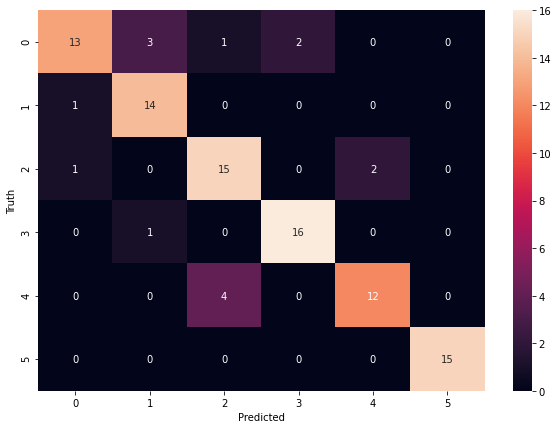

In [117]:
import seaborn as sn
cm=tf.math.confusion_matrix(labels=y_test_class,predictions=y_pred_class)

plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [118]:
#Accuracy
acc=(13+14+15+16+12+15)/(19+15+18+17+16+15)
acc

0.85